In [5]:
import os
import glob
import re
import decimal

In [6]:
notebook = """Jupyter Notebook
humbleCDCL
Last Checkpoint: 13 godzin temu
(unsaved changes)
Current Kernel Logo
Logout
Python 3 Trusted
File
Edit
View
Insert
Cell
Kernel
Widgets
Help
Run
In [36]:

import tensorflow as tf
from tensorflow.contrib import predictor
​
export_dir = "gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/"
predict_fn = predictor.from_saved_model(export_dir)
INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/variables/variables
In [37]:

from matplotlib import pyplot as plt
import numpy as np
import random
In [65]:

import tqdm
In [39]:

from time import time
In [40]:

import sys 
sys.path.insert(0,'../..')
In [41]:

from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL, JeroslowWangDPLL
import cdcl
CDCL = cdcl.CDCL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR, get_sat_SR, get_random_sat_kcnf
from tqdm import tqdm
from collections import Counter
In [42]:

LIMIT_RUNS = 1000
In [43]:

CDCL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))
Out[43]:
[1, -2]
In [44]:

JeroslowWangDPLL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))
Out[44]:
[1, -2]
In [45]:

cnf = get_pos_SR(15, 15, 2000)
print("Generated")
# print(cnf)
start = time()
CDCL().run(cnf)
end = time()
print(end-start)
start = time()
DPLL().run(cnf)
end = time()
print(end-start)
Generated
0.02811431884765625
0.018420696258544922
In [46]:

import math
from collections import defaultdict
​
def jw(clauses):
    score = defaultdict(int)
​
    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))
​
    return max(score, key=score.get)
In [47]:

jw([[-1, -2], [+1, -2]])
Out[47]:
-2
In [48]:

np.set_printoptions(precision=3, suppress=True)
In [49]:

import tensorflow as tf
import os
​
BATCH_SIZE = 1
In [50]:

VERBOSE = False
TIMEOUT = 10000
cdcl.VERBOSE = VERBOSE
cdcl.TIMEOUT = TIMEOUT
​
class GraphBasedCDCL(CDCL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        output = predict_fn({"input": inputs})
        policy_probs = output['policy_probabilities']
        sat_prob = output['sat_probabilities'][0]
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        #print("best_svar:", best_svar, file=logfile)
        if VERBOSE:
            print("Chosen neural", best_svar)
            print("Pred SAT prob", sat_prob)
        return best_svar
​
class HumbleGraphBasedCDCL(CDCL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        output = predict_fn({"input": inputs})
        policy_probs = output['policy_probabilities']
        sat_prob = output['sat_probabilities'][0]
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        #print("best_svar:", best_svar, file=logfile)
        if VERBOSE:
            print("Chosen neural", best_svar)
            print("Pred SAT prob", sat_prob)
        if sat_prob < 0.3:
            # Overwriting with JW
            best_svar = jw(input_cnf.clauses)
            if VERBOSE:
                print("Choosing JW", best_svar)
        #if sat_prob < 0.02:
        #    print("Aborting, prob too small")
        #    raise ValueError("Prob too small")
        return best_svar
​
class JeroslawCDCL(CDCL):
    def suggest(self, cnf: CNF):
        res = jw(cnf.clauses)
        if VERBOSE:
            print("Chosen JW", res)
        return res
In [51]:

HumbleGraphBasedCDCL().run(CNF([[-1, -2], [+1, +3], [+2, -3], [+3, -2], [+1, -2], [2, 3]]))
In [52]:

def compute_steps(sats, cdcl_cls):
    steps = []
    solved = 0
    for sat in tqdm.tqdm(sats):
        cdcl = cdcl_cls()
        res = cdcl.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(cdcl.number_of_runs)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps
In [62]:

def compute_and_print_steps(sats, dpll_cls):
    try:
        print("")
        print("Results of {}".format(dpll_cls.__name__))
        steps = compute_steps(sats, dpll_cls)
        print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}".format(
            len(steps), np.mean(steps), np.std(steps)))
        print("Table: {}".format(steps))
    except Exception as e:
        print(e)
        print("Timeout!", TIMEOUT, "steps")
​
In [63]:

def print_all(s, n, m, light=False, seed=1, to_test=[HumbleGraphBasedCDCL, GraphBasedCDCL, JeroslawCDCL]):
    print("Starting...")
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(seed)
    np.random.seed(seed)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    # compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    
    #compute_and_print_steps(sats, GraphBasedCDCL)
    for method in to_test:
        compute_and_print_steps(sats, method)
    #logfile.flush()
In [21]:

#print_all(10, 200, 50)
In [30]:

print_all(30, 1000, 40)
Starting...
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 30/30 [01:49<00:00,  2.23s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 32.80; stdev step: 42.92
Table: [11, 17, 11, 20, 17, 41, 14, 15, 18, 25, 158, 56, 13, 10, 11, 13, 6, 19, 157, 16, 35, 158, 39, 17, 14, 14, 10, 17, 19, 13]

Results of GraphBasedCDCL
100%|██████████| 30/30 [02:36<00:00,  2.74s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 49.37; stdev step: 85.94
Table: [11, 17, 11, 20, 17, 28, 14, 15, 18, 25, 351, 84, 13, 10, 11, 13, 6, 19, 251, 16, 87, 293, 32, 17, 14, 14, 10, 17, 34, 13]

Results of JeroslawCDCL
100%|██████████| 30/30 [00:14<00:00,  2.04it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 34.17; stdev step: 18.73
Table: [51, 79, 58, 11, 11, 36, 50, 45, 25, 42, 18, 52, 54, 9, 16, 15, 20, 25, 70, 51, 21, 41, 35, 27, 48, 17, 30, 12, 45, 11]

In [31]:

print_all(30, 1000, 50)
Starting...
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 30/30 [03:11<00:00,  3.36s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 49.60; stdev step: 60.84
Table: [14, 10, 25, 31, 17, 16, 24, 20, 21, 13, 24, 21, 254, 90, 18, 103, 160, 22, 203, 148, 44, 24, 15, 21, 16, 25, 32, 29, 24, 24]

Results of GraphBasedCDCL
100%|██████████| 30/30 [05:37<00:00,  4.02s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 86.53; stdev step: 142.90
Table: [14, 13, 25, 31, 17, 16, 24, 20, 21, 13, 24, 21, 485, 155, 18, 135, 446, 22, 424, 409, 52, 24, 15, 21, 16, 25, 32, 30, 24, 24]

Results of JeroslawCDCL
100%|██████████| 30/30 [00:46<00:00,  1.77s/it]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 75.53; stdev step: 67.41
Table: [20, 12, 110, 46, 59, 123, 58, 14, 115, 16, 25, 77, 175, 116, 288, 112, 85, 172, 19, 58, 40, 25, 23, 13, 25, 32, 102, 41, 229, 36]

In [32]:

print_all(30, 2000, 60)
Starting...
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 30/30 [13:37<00:00, 16.55s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 162.13; stdev step: 215.26
Table: [20, 19, 18, 163, 18, 155, 36, 661, 23, 107, 15, 256, 847, 543, 463, 26, 23, 443, 33, 27, 19, 45, 230, 29, 31, 28, 303, 19, 130, 134]

Results of GraphBasedCDCL
100%|██████████| 30/30 [45:22<00:00, 34.89s/it]   
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 493.50; stdev step: 725.35
Table: [20, 21, 18, 337, 18, 303, 36, 1866, 23, 174, 15, 858, 2431, 2254, 1226, 26, 1484, 1500, 33, 27, 19, 45, 628, 29, 31, 28, 1123, 19, 80, 133]

Results of JeroslawCDCL
100%|██████████| 30/30 [02:10<00:00,  2.08s/it]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 144.67; stdev step: 113.02
Table: [137, 174, 27, 117, 282, 332, 98, 142, 241, 378, 19, 417, 81, 246, 313, 17, 114, 105, 50, 35, 143, 43, 290, 106, 18, 41, 142, 86, 104, 42]

In [33]:

print_all(30, 2000, 70)
Starting...
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 30/30 [32:58<00:00, 64.87s/it] 
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 309.17; stdev step: 406.07
Table: [353, 620, 18, 25, 60, 22, 36, 24, 576, 814, 23, 423, 21, 35, 821, 24, 193, 173, 1859, 965, 23, 73, 56, 162, 450, 274, 176, 22, 789, 165]

Results of GraphBasedCDCL
100%|██████████| 30/30 [2:16:04<00:00, 457.92s/it]  
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 1061.13; stdev step: 1575.44
Table: [31, 2214, 18, 25, 60, 22, 36, 24, 2135, 2145, 23, 844, 21, 35, 3451, 24, 364, 942, 4531, 4942, 23, 26, 37, 229, 2265, 555, 718, 22, 5395, 677]

Results of JeroslawCDCL
100%|██████████| 30/30 [04:39<00:00,  3.47s/it]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 215.00; stdev step: 217.21
Table: [377, 244, 63, 159, 35, 140, 41, 33, 428, 983, 64, 255, 577, 611, 433, 37, 373, 78, 373, 87, 177, 84, 147, 181, 59, 83, 76, 20, 62, 170]

In [ ]:

print_all(30, 2000, 90)
Starting...
  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 30/30 [1:18:03<00:00, 131.10s/it]
  0%|          | 0/30 [00:00<?, ?it/s]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 523.77; stdev step: 651.80
Table: [55, 33, 540, 34, 648, 485, 42, 89, 35, 33, 40, 671, 2240, 71, 34, 34, 229, 202, 943, 32, 2179, 1675, 224, 1247, 1629, 897, 918, 178, 35, 241]

Results of GraphBasedCDCL
 67%|██████▋   | 20/30 [1:49:52<1:01:16, 367.62s/it]
In [ ]:

print_all(30, 2000, 110)
In [*]:

print("hi")
In [66]:

print_all(30, 20000, 90, to_test=[JeroslawCDCL])
Starting...


  0%|          | 0/30 [00:00<?, ?it/s]
We have generated 30 formulas

Results of JeroslawCDCL


  3%|▎         | 1/30 [01:28<42:45, 88.47s/it]

  7%|▋         | 2/30 [02:37<38:31, 82.55s/it]

 10%|█         | 3/30 [03:24<32:24, 72.01s/it]

 13%|█▎        | 4/30 [03:25<21:59, 50.77s/it]

 17%|█▋        | 5/30 [17:50<2:02:54, 294.98s/it]

 20%|██        | 6/30 [20:05<1:38:46, 246.96s/it]

 23%|██▎       | 7/30 [20:09<1:06:43, 174.07s/it]

 27%|██▋       | 8/30 [21:31<53:41, 146.43s/it]  

 30%|███       | 9/30 [21:32<35:56, 102.70s/it]

 33%|███▎      | 10/30 [21:35<24:20, 73.00s/it]

 37%|███▋      | 11/30 [23:20<26:09, 82.60s/it]

 40%|████      | 12/30 [23:47<19:42, 65.68s/it]

 43%|████▎     | 13/30 [25:09<20:00, 70.60s/it]

 47%|████▋     | 14/30 [25:15<13:41, 51.32s/it]

 50%|█████     | 15/30 [26:06<12:47, 51.18s/it]

 53%|█████▎    | 16/30 [26:06<08:23, 35.97s/it]

 57%|█████▋    | 17/30 [26:39<07:36, 35.14s/it]

 60%|██████    | 18/30 [28:23<11:08, 55.67s/it]

 63%|██████▎   | 19/30 [33:35<24:17, 132.47s/it]

 67%|██████▋   | 20/30 [33:40<15:44, 94.45s/it] 

 70%|███████   | 21/30 [35:18<14:19, 95.46s/it]

 73%|███████▎  | 22/30 [35:51<10:12, 76.58s/it]

 77%|███████▋  | 23/30 [35:51<06:16, 53.74s/it]

 80%|████████  | 24/30 [38:59<09:23, 93.97s/it]

 83%|████████▎ | 25/30 [39:25<06:08, 73.68s/it]

 87%|████████▋ | 26/30 [41:56<06:26, 96.67s/it]

 90%|█████████ | 27/30 [42:14<03:39, 73.23s/it]

 93%|█████████▎| 28/30 [43:24<02:24, 72.20s/it]

 97%|█████████▋| 29/30 [45:44<01:32, 92.67s/it]

100%|██████████| 30/30 [46:10<00:00, 72.45s/it]
Within 1000 steps solved 30 problems out of 30
#Sats: 30; avg step: 851.00; stdev step: 806.57
Table: [1088, 956, 674, 44, 3959, 1381, 123, 961, 31, 102, 1184, 459, 1038, 149, 762, 30, 568, 1187, 2305, 139, 1130, 595, 29, 1671, 471, 1446, 347, 855, 1427, 419]
In [ ]:

​


"""

In [7]:
lines = notebook.strip().split('\n')
filtered = [line for line in lines if ('avg step: ' in line) or ('print_all(' in line)][3:]

In [8]:
filtered

['print_all(30, 1000, 40)',
 '#Sats: 30; avg step: 32.80; stdev step: 42.92',
 '#Sats: 30; avg step: 49.37; stdev step: 85.94',
 '#Sats: 30; avg step: 34.17; stdev step: 18.73',
 'print_all(30, 1000, 50)',
 '#Sats: 30; avg step: 49.60; stdev step: 60.84',
 '#Sats: 30; avg step: 86.53; stdev step: 142.90',
 '#Sats: 30; avg step: 75.53; stdev step: 67.41',
 'print_all(30, 2000, 60)',
 '#Sats: 30; avg step: 162.13; stdev step: 215.26',
 '#Sats: 30; avg step: 493.50; stdev step: 725.35',
 '#Sats: 30; avg step: 144.67; stdev step: 113.02',
 'print_all(30, 2000, 70)',
 '#Sats: 30; avg step: 309.17; stdev step: 406.07',
 '#Sats: 30; avg step: 1061.13; stdev step: 1575.44',
 '#Sats: 30; avg step: 215.00; stdev step: 217.21',
 'print_all(30, 2000, 90)',
 '#Sats: 30; avg step: 523.77; stdev step: 651.80',
 'print_all(30, 2000, 110)',
 'print_all(30, 20000, 90, to_test=[JeroslawCDCL])',
 '#Sats: 30; avg step: 851.00; stdev step: 806.57']

In [9]:
import re

def parse_stat(x):
    m = re.match("#Sats: \d+; avg step: ([0-9\.]+); stdev step: ([0-9\.d]+)", x)
    return (decimal.Decimal(m.group(1)), decimal.Decimal(m.group(2))) if m is not None else None

new_filtered = [parse_stat(x) if parse_stat(x) is not None else x for x in filtered]

In [10]:
new_filtered

['print_all(30, 1000, 40)',
 (Decimal('32.80'), Decimal('42.92')),
 (Decimal('49.37'), Decimal('85.94')),
 (Decimal('34.17'), Decimal('18.73')),
 'print_all(30, 1000, 50)',
 (Decimal('49.60'), Decimal('60.84')),
 (Decimal('86.53'), Decimal('142.90')),
 (Decimal('75.53'), Decimal('67.41')),
 'print_all(30, 2000, 60)',
 (Decimal('162.13'), Decimal('215.26')),
 (Decimal('493.50'), Decimal('725.35')),
 (Decimal('144.67'), Decimal('113.02')),
 'print_all(30, 2000, 70)',
 (Decimal('309.17'), Decimal('406.07')),
 (Decimal('1061.13'), Decimal('1575.44')),
 (Decimal('215.00'), Decimal('217.21')),
 'print_all(30, 2000, 90)',
 (Decimal('523.77'), Decimal('651.80')),
 'print_all(30, 2000, 110)',
 'print_all(30, 20000, 90, to_test=[JeroslawCDCL])',
 (Decimal('851.00'), Decimal('806.57'))]

In [11]:
new_filtered[20]

(Decimal('851.00'), Decimal('806.57'))

In [12]:
humble = new_filtered[:18][1::4]
graph = new_filtered[:18][2::4]
jeroslaw = new_filtered[:18][3::4] + [new_filtered[20]]

In [13]:
x = [40, 50, 60, 70, 90]

In [14]:
from matplotlib import pyplot as plt

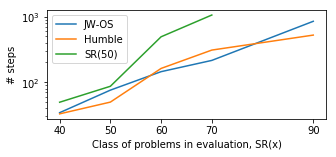

In [15]:
plt.figure(figsize=(5, 2))
plt.yscale('log', basey=10) 
plt.plot(x[:len(jeroslaw)], [t[0] for t in jeroslaw], '')
plt.plot(x[:len(humble)], [t[0] for t in humble], '')
plt.plot(x[:len(graph)], [t[0] for t in graph], '')
plt.xticks(x)
plt.legend(['JW-OS', 'Humble', 'SR(50)'])
plt.ylabel("# steps")
plt.xlabel("Class of problems in evaluation, SR(x)")
plt.savefig("sr-cdcl-steps.pdf", bbox_inches = "tight")

In [16]:
import numpy
array = numpy.array([jeroslaw, humble, graph])
print(' \\\\\n'.join(' & '.join("{}±{}".format(value[0], value[1]) for value in row) for row in array))

34.17±18.73 & 75.53±67.41 & 144.67±113.02 & 215.00±217.21 & 851.00±806.57 \\
32.80±42.92 & 49.60±60.84 & 162.13±215.26 & 309.17±406.07 & 523.77±651.80 \\
49.37±85.94 & 86.53±142.90 & 493.50±725.35 & 1061.13±1575.44
